# Experiment: Population Diseases

Water-related diseases are a major cause of death worldwide. In this experiment, we will try to find out if there is a correlation between the number of people affected by water-related diseases and other water-related variables.

Since diseases don't occur directly we have to consider a lag period. For example, if we want to find out if the number of people affected by water-related diseases in 2020 is correlated with, e.g., the water withdrawal for aquaculture in 2010, we have to consider a lag period of 10 years.

In [1]:
import os
import sys

sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

from tueplots import bundles
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({"figure.dpi": 200})

import pandas as pd
# Stop pandas from complaining about performance
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
from src.aquastat_utils import get_aquastat

aquastat_df = get_aquastat()

water_related_disease_variable = 'Population affected by water related disease'

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/Users/josef/projects/test/team-aqua/src/../dat/fao_aquastat.csv already exists.
Getting AQUASTAT dataframe from fao_aquastat.csv ...
/Users/josef/projects/test/team-aqua/src/../dat/fao_aquastat.csv already exists.
Renaming countries ...


In [3]:
aquastat_df[water_related_disease_variable].describe()

count      672.000000
mean      2256.415662
std       8128.608780
min          0.000000
25%         12.000000
50%        177.600000
75%        960.000000
max      44000.000000
Name: Population affected by water related disease, dtype: float64

In [4]:
aquastat_df[['Country', 'Year', water_related_disease_variable]].dropna()

Variable,Country,Year,Population affected by water related disease
389,Argentina,2011,5607.0
390,Argentina,2012,5607.0
391,Argentina,2013,5607.0
392,Argentina,2014,5607.0
393,Argentina,2015,5607.0
...,...,...,...
10396,Vietnam,2016,177.6
10397,Vietnam,2017,177.6
10398,Vietnam,2018,177.6
10399,Vietnam,2019,177.6


Saving figure to fig/water_management/fig_world_map_Population_affected_by_water_related_disease_2020.pdf ... Done!


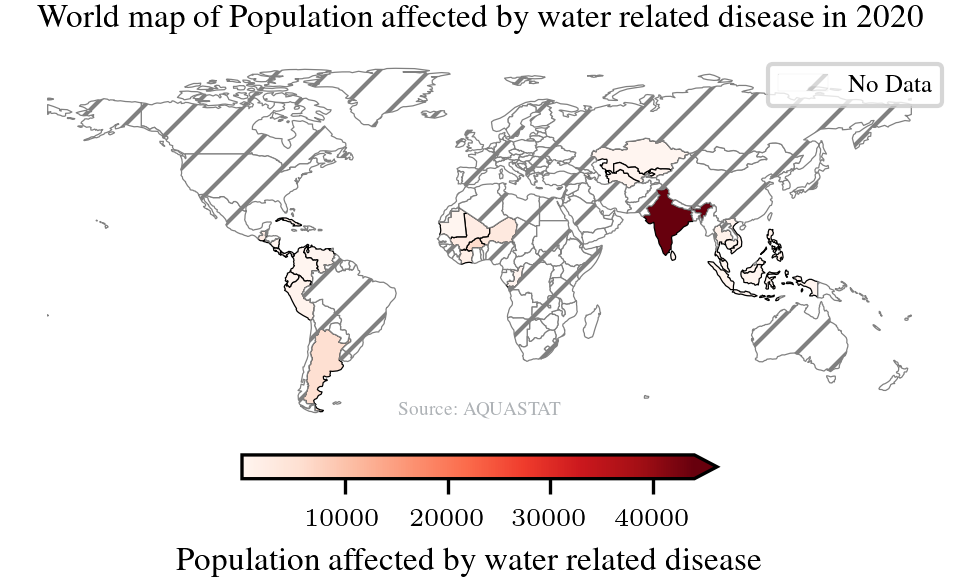

(<Figure size 975x602.583 with 2 Axes>,
 <Axes: title={'center': 'World map of Population affected by water related disease in 2020'}>)

In [5]:
from src.aquastat_plot import plot_world

year = 2020

'''Plot a world map'''
plot_world(aquastat_df, variable=water_related_disease_variable, year=year, cmap='Reds', title=f"World map of {water_related_disease_variable} in {year}")

In [6]:
variables_related_to_water_diseases = [
    "Agricultural water withdrawal",
    "Agricultural water withdrawal as % of total water withdrawal",
    "Area equipped for irrigation by direct use of treated municipal wastewater",
    "Capacity of the municipal wastewater treatment facilities",
    "Collected municipal wastewater",
    "Direct use of treated municipal wastewater",
    "Direct use of not treated municipal wastewater for irrigation purposes",
    "Not treated municipal wastewater",
    "Not treated municipal wastewater discharged (secondary water)",
    "Produced municipal wastewater",
    "Treated municipal wastewater",
    "Treated municipal wastewater discharged (secondary water)",
    "Water resources: total external renewable",
    "Water withdrawal for aquaculture",
    "Water withdrawal for livestock (watering and cleaning)"
]

# Maximum lag period to test
MAX_LAG = 10  # Adjust as needed

# List to store temporary DataFrames for each lagged variable
temp_dfs = []

for var in variables_related_to_water_diseases:
    # Check if the variable has constant values
    if aquastat_df[var].nunique() <= 1:
        print(f"Variable '{var}' has no variation (constant values) and will be skipped.")
        continue

    for lag in range(1, MAX_LAG + 1):
        # Create lagged variable
        lagged_var_name = f'{var}_lagged_{lag}'
        aquastat_df[lagged_var_name] = aquastat_df[var].shift(lag)

        # Remove rows with NaN values
        temp_df = aquastat_df.dropna(subset=[lagged_var_name, water_related_disease_variable])

        # Check if lagged variable has enough variations
        if temp_df[lagged_var_name].std() != 0:
            corr = temp_df[lagged_var_name].corr(temp_df[water_related_disease_variable])
            temp_dfs.append(pd.DataFrame({'Variable': [var], 'Lag': [lag], 'Correlation': [corr]}))

# Concatenate all temporary DataFrames
correlations = pd.concat(temp_dfs, ignore_index=True) if temp_dfs else pd.DataFrame()

# Drop NaN values from correlations (if any)
correlations.dropna(inplace=True)

# Find the variable with the highest absolute correlation
if not correlations.empty:
    highest_corr = correlations.loc[correlations['Correlation'].abs().idxmax()]
    print("Variable with the highest correlation:", highest_corr)
else:
    print("No valid correlations found.")
correlations

Variable with the highest correlation: Variable       Water withdrawal for aquaculture
Lag                                          10
Correlation                            0.973674
Name: 129, dtype: object


,Variable,Lag,Correlation
0,Agricultural water withdrawal,1,0.939409
1,Agricultural water withdrawal,2,0.939829
2,Agricultural water withdrawal,3,0.940306
3,Agricultural water withdrawal,4,0.940848
4,Agricultural water withdrawal,5,0.940966
...,...,...,...
135,Water withdrawal for livestock (watering and c...,6,-0.119992
136,Water withdrawal for livestock (watering and c...,7,-0.106983
137,Water withdrawal for livestock (watering and c...,8,-0.093119
138,Water withdrawal for livestock (watering and c...,9,-0.068012


In [7]:
'''Keep only the variables with a correlation above a threshold'''

CORRELATION_THRESHOLD = 0.9
# Find the variables which have anytime a correlation above the threshold
correlations = correlations.groupby('Variable').filter(lambda x: x['Correlation'].abs().max() >= CORRELATION_THRESHOLD)
correlations

,Variable,Lag,Correlation
0,Agricultural water withdrawal,1,0.939409
1,Agricultural water withdrawal,2,0.939829
2,Agricultural water withdrawal,3,0.940306
3,Agricultural water withdrawal,4,0.940848
4,Agricultural water withdrawal,5,0.940966
5,Agricultural water withdrawal,6,0.940778
6,Agricultural water withdrawal,7,0.940437
7,Agricultural water withdrawal,8,0.940106
8,Agricultural water withdrawal,9,0.939976
9,Agricultural water withdrawal,10,0.940700


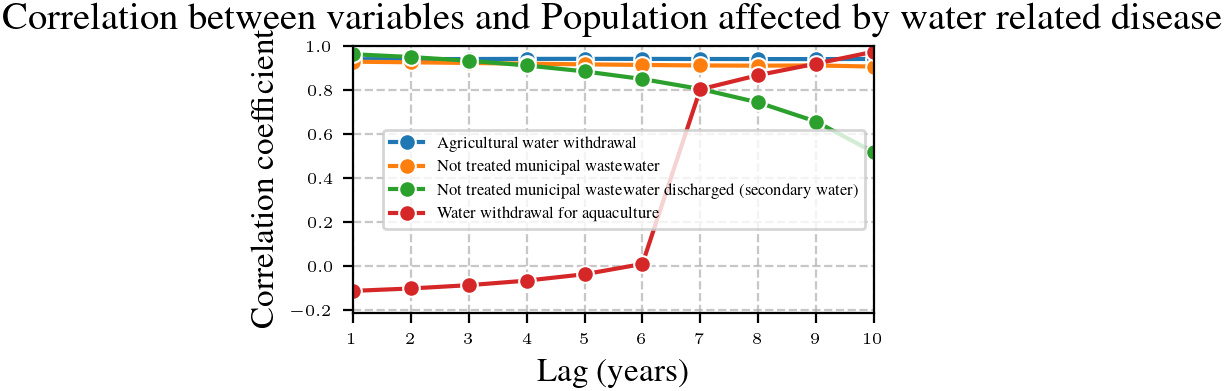

In [8]:
'''Plot the correlations'''
TITLE = f"Correlation between variables and {water_related_disease_variable}"
X_LABEL = "Lag (years)"
Y_LABEL = "Correlation coefficient"

# Create the plot
fig, ax = plt.subplots()

# Plot each variable with different alpha based on the threshold
for var in correlations['Variable'].sort_values().unique():
    var_data = correlations[correlations['Variable'] == var]
    alpha_value = 0.1 if abs(var_data['Correlation']).max() < CORRELATION_THRESHOLD else 1
    sns.lineplot(data=var_data, x='Lag', y='Correlation', label=var, ax=ax, marker='o', alpha=alpha_value)

# Set title and labels
ax.set_title(TITLE, fontsize=14, fontweight='bold')
ax.set_xlabel(X_LABEL, fontsize=12)
ax.set_ylabel(Y_LABEL, fontsize=12)

# Setup axis
ax.set_xlim(1, MAX_LAG)
ax.set_ylim(correlations['Correlation'].min() - 0.1, 1)  # Dynamic y-axis limit based on data

# Improve the legend
handles, labels = ax.get_legend_handles_labels()

# Add a legend
ax.legend()

# Add grid
ax.grid(True, axis='both', linestyle='--', alpha=0.7)

plt.show()
